In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    median_absolute_error, explained_variance_score, max_error)
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor, HuberRegressor, ElasticNet
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")
SEED = 42
rng = np.random.RandomState(SEED)

# Этап 1:
- загрузка данных
- проверка данных
- дополнительная предобработка

In [19]:
df = pd.read_csv('cian_processed_data-2.csv')

In [20]:
print(df.shape)
print(df.head())
print(df.describe())
print(df.columns)

(7109, 42)
        price  rooms_count  floor  floors_count  text_len  building_year  \
0   8799000.0          1.0      3            10      1242         2023.0   
1   7200000.0          2.0      8             9      1598         1985.0   
2   9666161.0          1.0     10            13      2235         2026.0   
3  13016046.0          2.0      2            13      2269         2026.0   
4   3300000.0          1.0      1             5      1317         1968.0   

   building_age  is_completed  living_share  ceiling_height_m  ...  \
0           2.0           1.0      0.294278               2.8  ...   
1          40.0           1.0      0.600000               2.6  ...   
2          -1.0           0.0      0.557711               2.7  ...   
3          -1.0           0.0      0.595012               2.7  ...   
4          57.0           1.0      0.659574               2.6  ...   

   has_security  city_Казань  city_Махачкала  city_Москва  city_Пермь  \
0         False         True          

Небольшая предобработка

In [21]:
def preprocess(df: pd.DataFrame):
    df = df.copy()

    #таргет - price_log
    y = df['price_log'].astype(float)
    if 'price' in df.columns:
        df.drop(columns=['price'], inplace=True)

    if 'floor' in df.columns:
        f = df['floor']
        df['floor_lt5']  = (f < 5).astype('uint8')
        df['floor_5_10'] = ((f >= 5) & (f <= 10)).astype('uint8')
        df['floor_gt10'] = (f > 10).astype('uint8')
        df.drop(columns=['floor'], inplace=True)

    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype('uint8')

    #проверка пропусков
    assert not df.isna().any().any(), "Обнаружены пропуски"

    #формируем X
    X = df.drop(columns=['price_log'])
    return X, y

X, y = preprocess(df)
print(X.dtypes.value_counts())
X[X['city_Махачкала'] == 1].head() # проверка

uint8      29
float64     8
int64       5
Name: count, dtype: int64


,rooms_count,floors_count,text_len,building_year,building_age,is_completed,living_share,ceiling_height_m,is_first_floor,is_top_floor,...,city_Махачкала,city_Москва,city_Пермь,city_Санкт-Петербург,city_Сочи,city_Ярославль,sqrt_total_meters,floor_lt5,floor_5_10,floor_gt10
1421,1.0,5,1467,1980.0,45.0,1.0,0.421053,2.8,0,1,...,1,0,0,0,0,0,6.164414,0,1,0
1422,3.0,6,553,2002.0,23.0,1.0,0.629493,3.0,0,0,...,1,0,0,0,0,0,10.549882,0,1,0
1423,1.0,11,229,2019.0,6.0,1.0,0.500000,3.0,1,0,...,1,0,0,0,0,0,6.708204,1,0,0
1424,2.0,4,482,2016.0,9.0,1.0,0.400000,3.0,0,0,...,1,0,0,0,0,0,7.071068,1,0,0
1425,2.0,3,1406,1958.0,67.0,1.0,0.588235,3.0,1,0,...,1,0,0,0,0,0,7.141428,1,0,0


# Этап 2: Линейная регрессия
- Делим данные на 3 выборки
  - обучать будем на train, а смотреть результаты по validation. test создается для дальнейших моделей
- Обучаем модель
- Смотрим метрики
- Проводим тест значимости переменных

Делим данные

In [22]:
# 80 / 10 / 10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train.shape, X_val.shape, X_test.shape


((5687, 42), (711, 42), (711, 42))

Линейная регрессия

In [23]:
# добавляем константу
X_train_const = sm.add_constant(X_train)
X_val_const   = sm.add_constant(X_val, has_constant='add')

# обучение
model = sm.OLS(y_train, X_train_const).fit()

# предсказание на train и val
y_train_pred = model.predict(X_train_const)
y_val_pred   = model.predict(X_val_const)

# краткий summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     902.0
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:05:32   Log-Likelihood:                -2586.2
No. Observations:                5687   AIC:                             5254.
Df Residuals:                    5646   BIC:                             5527.
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   98.1383 

Метрики

In [24]:
def print_metrics(y_true, y_pred, name='Set', n_features=None):
    n = len(y_true)
    p = n_features if n_features else 0

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if p else r2
    medae = median_absolute_error(y_true, y_pred)
    evs   = explained_variance_score(y_true, y_pred)
    mape  = np.mean(np.abs((np.expm1(y_pred) - np.expm1(y_true)) / np.expm1(y_true))) * 100
    maxerr = max_error(y_true, y_pred)

    # красивый вывод нам написал гпт
    print(f'📊 {name} metrics:')
    print(f'RMSE: {rmse:.4f}')
    print(f'MAE : {mae:.4f}')
    print(f'R²  : {r2:.4f}')
    print(f'Adj.R²: {adj_r2:.4f}')
    print(f'Median AE: {medae:.4f}')
    print(f'Explained Var: {evs:.4f}')
    print(f'MAPE: {mape:.2f}%')
    print(f'Max Error: {maxerr:.4f}\n')

print_metrics(y_train, y_train_pred, 'Train')
print_metrics(y_val, y_val_pred, 'Validation')


📊 Train metrics:
RMSE: 0.3813
MAE : 0.2667
R²  : 0.8647
Adj.R²: 0.8647
Median AE: 0.1932
Explained Var: 0.8647
MAPE: 29.97%
Max Error: 3.7174

📊 Validation metrics:
RMSE: 0.4154
MAE : 0.2710
R²  : 0.8297
Adj.R²: 0.8297
Median AE: 0.1956
Explained Var: 0.8299
MAPE: 57.12%
Max Error: 5.3117



Давайте посмотрим еще на тестовой выборке

In [25]:
X_test_const = sm.add_constant(X_test, has_constant='add')
y_test_pred = model.predict(X_test_const)

print_metrics(y_test, y_test_pred, 'Test', n_features=X_train.shape[1])

📊 Test metrics:
RMSE: 0.3797
MAE : 0.2689
R²  : 0.8787
Adj.R²: 0.8711
Median AE: 0.1919
Explained Var: 0.8789
MAPE: 28.74%
Max Error: 1.6644



Лучшие метрики среди всех (RMSE 0.38, R² 0.88, MAPE 29%). Модель хорошо обобщается на данных, которые еще не видела.
- Переобучения нет.
- Max error 1.66 - стабильность.

Тест значимости переменных

In [26]:
def _stars(p):
    return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''

def print_significance_table(model, sort_by='pval'):
    coef   = model.params
    se     = model.bse
    tvals  = model.tvalues
    pvals  = model.pvalues
    ci     = model.conf_int(alpha=0.05)
    ci.columns = ['ci_2.5%', 'ci_97.5%']

    df_sig = pd.concat([coef.rename('coef'),
                        se.rename('std_err'),
                        tvals.rename('t'),
                        pvals.rename('pval'),
                        ci], axis=1)

    df_sig['sig'] = df_sig['pval'].apply(_stars)

    if sort_by in ('pval', 't', 'abs_t'):
        key = 'pval' if sort_by == 'pval' else ('t' if sort_by == 't' else None)
        if sort_by == 'abs_t':
            df_sig = df_sig.reindex(df_sig['t'].abs().sort_values(ascending=False).index)
        else:
            df_sig = df_sig.sort_values(by=key, ascending=(sort_by=='pval'))

    df_print = df_sig.copy()
    num_cols = ['coef', 'std_err', 't', 'pval', 'ci_2.5%', 'ci_97.5%']
    df_print[num_cols] = df_print[num_cols].astype(float).round(6)


    print(f'Variables significance (sorted by {sort_by}):')
    print(df_print.to_string())

print_significance_table(model, sort_by='pval')


Variables significance (sorted by pval):
                           coef    std_err          t      pval    ci_2.5%    ci_97.5%  sig
sqrt_total_meters      0.297887   0.005238  56.874446  0.000000   0.287619    0.308154  ***
is_central             0.224990   0.014434  15.587285  0.000000   0.196693    0.253287  ***
is_completed          -0.180680   0.019249  -9.386355  0.000000  -0.218416   -0.142944  ***
has_parking            0.149565   0.017518   8.537712  0.000000   0.115223    0.183907  ***
has_security           0.137377   0.016274   8.441544  0.000000   0.105474    0.169280  ***
near_grocery          -0.082943   0.011518  -7.201130  0.000000  -0.105523   -0.060363  ***
near_park              0.071884   0.012025   5.978009  0.000000   0.048311    0.095457  ***
is_first_floor        -0.113710   0.020092  -5.659332  0.000000  -0.153098   -0.074321  ***
rooms_count           -0.047892   0.009021  -5.308799  0.000000  -0.065578   -0.030207  ***
text_len               0.000055   0.000

Получаем очевидные результаты -
1) mat_panel, mat_block, mat_monolith - коррелирующие, нужно убрать одну из них
2) floor_ratio тоже коррелирует с другими параметрами про этажность
3) floor_5_10 и другие созданные в начале признаки тоже высококоррелируют. Нужно убрать один из них.
4) near_metro - тоже показатель слабо влияет тк метро есть только в Москве и Питере
5) Флаги по городам тоже высоко коррелируемы, тк только по этим городам и есть данные

Это хорошо, значит наша модель адекватная.

# Этап 2.1: Убираем некоторые признаки и сравниваем результаты
- Делаем новую предобработку
- Обучаем модель
- Смотрим на значимость оставшихся парамаетров
- Чистим еще раз от незначимых параметров
- Обучаем еще раз
- Сравниваем результаты

Сделаем новую предобработку и повторим шаги.

In [27]:
df = pd.read_csv('cian_processed_data-2.csv')


def preprocess(df: pd.DataFrame):
    df = df.copy()

    y = df['price_log'].astype(float)
    if 'price' in df.columns:
        df.drop(columns=['price'], inplace=True)

    if 'floor' in df.columns:
        f = df['floor']
        df['floor_lt5']  = (f < 5).astype('uint8')
        df['floor_5_10'] = ((f >= 5) & (f <= 10)).astype('uint8')
        df['floor_gt10'] = (f > 10).astype('uint8')
        df.drop(columns=['floor'], inplace=True)

    if 'floor_gt10' in df.columns:
        df.drop(columns=['floor_gt10'], inplace=True)


    if 'near_metro' in df.columns and 'city_Москва' in df.columns:
        df['near_metro_city_moscow'] = (df['near_metro'].astype('uint8') * df['city_Москва'].astype('uint8')).astype('uint8')
        df.drop(columns=['city_Москва'], inplace=True, errors='ignore')

    if 'mat_panel' in df.columns:
        df.drop(columns=['mat_panel'], inplace=True)

    for col in ['building_year', 'floor_ratio']:
        if col in df.columns:
            df.drop(columns=[col], inplace=True)

    bool_cols = df.select_dtypes(include='bool').columns
    if len(bool_cols) > 0:
        df[bool_cols] = df[bool_cols].astype('uint8')

    assert not df.isna().any().any(), "Обнаружены пропуски"

    X = df.drop(columns=['price_log'])
    return X, y


X, y = preprocess(df)
print(X.shape, y.shape)
X.dtypes.value_counts()


(7109, 38) (7109,)


,count
uint8,27
float64,6
int64,5


Обучаем модель

In [28]:
# 80 / 10 / 10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_2, X_val_2, X_test_2 = X_train, X_val, X_test # для сравнения остальных моделей

X_train_const = sm.add_constant(X_train)
X_val_const   = sm.add_constant(X_val, has_constant='add')

model = sm.OLS(y_train, X_train_const).fit()

y_train_pred = model.predict(X_train_const)
y_val_pred   = model.predict(X_val_const)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     946.3
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:05:33   Log-Likelihood:                -2595.3
No. Observations:                5687   AIC:                             5269.
Df Residuals:                    5648   BIC:                             5528.
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     15

Смотрим на метрики новой модели

In [29]:
print_metrics(y_train, y_train_pred, 'Train')
print_metrics(y_val, y_val_pred, 'Validation')

📊 Train metrics:
RMSE: 0.3819
MAE : 0.2669
R²  : 0.8643
Adj.R²: 0.8643
Median AE: 0.1923
Explained Var: 0.8643
MAPE: 30.00%
Max Error: 3.7211

📊 Validation metrics:
RMSE: 0.4148
MAE : 0.2696
R²  : 0.8301
Adj.R²: 0.8301
Median AE: 0.1906
Explained Var: 0.8303
MAPE: 57.20%
Max Error: 5.3171



Смотрим на значимость показателей

In [30]:
print_significance_table(model, sort_by='pval')

Variables significance (sorted by pval):
                             coef   std_err           t      pval    ci_2.5%   ci_97.5%  sig
const                   15.120316  0.068698  220.099001  0.000000  14.985642  15.254990  ***
sqrt_total_meters        0.296258  0.005254   56.383712  0.000000   0.285957   0.306558  ***
city_Ярославль          -1.580469  0.038706  -40.832143  0.000000  -1.656349  -1.504589  ***
city_Махачкала          -1.518274  0.040059  -37.900581  0.000000  -1.596806  -1.439743  ***
city_Пермь              -1.407412  0.038290  -36.757105  0.000000  -1.482474  -1.332350  ***
city_Казань             -0.942230  0.038401  -24.536631  0.000000  -1.017511  -0.866949  ***
city_Санкт-Петербург    -0.703265  0.039695  -17.716650  0.000000  -0.781083  -0.625447  ***
is_central               0.229277  0.014409   15.912354  0.000000   0.201030   0.257524  ***
city_Сочи               -0.456691  0.038261  -11.936039  0.000000  -0.531698  -0.381683  ***
has_parking              0.15

Добавим еще изменений и сравним

In [31]:
import statsmodels.api as sm

drop_cols = ['floor_5_10', 'near_metro_city_moscow', 'living_share', 'has_balcony', 'mat_block']

def make_reduced(dfX):
    Xr = dfX.copy()
    for c in drop_cols:
        if c in Xr.columns:
            Xr.drop(columns=[c], inplace=True)
    return Xr

X_train_r = make_reduced(X_train)
X_val_r   = make_reduced(X_val)
X_test_r  = make_reduced(X_test)

X_train_r_const = sm.add_constant(X_train_r, has_constant='add')
X_val_r_const   = sm.add_constant(X_val_r,   has_constant='add')

model_reduced = sm.OLS(y_train, X_train_r_const).fit()
y_train_pred_r = model_reduced.predict(X_train_r_const)
y_val_pred_r   = model_reduced.predict(X_val_r_const)

print(model_reduced.summary())

print_metrics(y_train, y_train_pred_r, 'Train (Reduced)', n_features=X_train_r_const.shape[1]-1)
print_metrics(y_val,   y_val_pred_r,   'Validation (Reduced)', n_features=X_val_r_const.shape[1]-1)

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1090.
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        11:05:33   Log-Likelihood:                -2597.3
No. Observations:                5687   AIC:                             5263.
Df Residuals:                    5653   BIC:                             5489.
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   15.0658 

Смотрим на значимость

In [32]:
print_significance_table(model_reduced, sort_by='pval')

Variables significance (sorted by pval):
                           coef   std_err           t      pval    ci_2.5%   ci_97.5%  sig
const                 15.065817  0.053180  283.297809  0.000000  14.961564  15.170071  ***
city_Махачкала        -1.501531  0.033577  -44.719026  0.000000  -1.567354  -1.435707  ***
city_Ярославль        -1.560421  0.031107  -50.163200  0.000000  -1.621402  -1.499439  ***
city_Пермь            -1.388963  0.030660  -45.301732  0.000000  -1.449069  -1.328857  ***
sqrt_total_meters      0.297337  0.005206   57.118127  0.000000   0.287132   0.307542  ***
city_Казань           -0.920108  0.029532  -31.156564  0.000000  -0.978002  -0.862215  ***
city_Санкт-Петербург  -0.679474  0.030280  -22.439398  0.000000  -0.738835  -0.620113  ***
is_central             0.229502  0.014391   15.947493  0.000000   0.201290   0.257714  ***
city_Сочи             -0.439551  0.030421  -14.448770  0.000000  -0.499188  -0.379913  ***
has_parking            0.156672  0.017444    8.98

Сравниение метрик:
```
Метрика              | Модель 1      | Модель 2      | Модель 3
-----------------------------------------------------------
Train RMSE           | 0.3813        | 0.3819        | 0.3820
Train MAE            | 0.2667        | 0.2669        | 0.2671
Train R²             | 0.8647        | 0.8643        | 0.8642
Train Adj.R²         | 0.8647        | 0.8643        | 0.8634
Train Median AE      | 0.1932        | 0.1923        | 0.1936
Train Explained Var  | 0.8647        | 0.8643        | 0.8642
Train MAPE           | 29.97%        | 30.00%        | 30.00%
Train Max Error      | 3.7174        | 3.7211        | 3.7170

Validation RMSE      | 0.4154        | 0.4148        | 0.4151
Validation MAE       | 0.2710        | 0.2696        | 0.2701
Validation R²        | 0.8297        | 0.8301        | 0.8299
Validation Adj.R²    | 0.8297        | 0.8301        | 0.8216
Validation Median AE | 0.1956        | 0.1906        | 0.1921
Validation Expl Var  | 0.8299        | 0.8303        | 0.8301
Validation MAPE      | 57.12%        | 57.20%        | 57.02%
Validation Max Error | 5.3117        | 5.3171        | 5.3102
```



Модель 2 является оптимальной - она показывает стабильно хорошие результаты на валидации при меньшем количестве признаков.

- Лучшие показатели на валидации (RMSE, MAE, R²) и лучшая медианная ошибка, наименьшее переобучение среди всех моделей.
- Существенное падение Adj.R² на валидации (0.8216) у модели 3

# Этап 3:
- обучение "в лоб", стандартные параметры, без обработки inf и тд
- LinearRegression / Ridge / Lasso
- Градиентный спуск: Batch / Mini-batch / SGD (без штрафа)
- Регуляризация через ГД: L2 / L1 (лог-сетка α)
- Huber (робастная потеря) — короткая δ-сетка
- Вывод результатов

Заново загружаем данные, предобработка, делим на выборки, подготовка вспомогательных функций

In [37]:
df = pd.read_csv('cian_processed_data-2.csv')

def preprocess(df: pd.DataFrame):
    df = df.copy()

    y = df['price_log'].astype(float)
    if 'price' in df.columns:
        df.drop(columns=['price'], inplace=True)

    if 'floor' in df.columns:
        f = df['floor']
        df['floor_lt5']  = (f < 5).astype('uint8')
        df['floor_5_10'] = ((f >= 5) & (f <= 10)).astype('uint8')
        df['floor_gt10'] = (f > 10).astype('uint8')
        df.drop(columns=['floor'], inplace=True)

    bool_cols = df.select_dtypes(include='bool').columns
    df[bool_cols] = df[bool_cols].astype('uint8')

    assert not df.isna().any().any(), "Обнаружены пропуски"

    X = df.drop(columns=['price_log'])
    return X, y

X, y = preprocess(df)
#print(X.dtypes.value_counts())
#print(X[X['city_Махачкала'] == 1].head()) # проверка


# 80 / 10 / 10
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_2.shape, X_val_2.shape, X_test_2.shape)

X_train, X_val, X_test = X_train_2, X_val_2, X_test_2 # на модели 2


(5687, 42) (711, 42) (711, 42)
(5687, 38) (711, 38) (711, 38)


In [38]:
num_cols = [c for c in X_train.columns if X_train[c].dtype != 'uint8']
bin_cols = [c for c in X_train.columns if X_train[c].dtype == 'uint8']

ct = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('bin', 'passthrough', bin_cols)
])

Xtr = ct.fit_transform(X_train)
Xvl = ct.transform(X_val)
ytr = y_train.values
yvl = y_val.values

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    med  = median_absolute_error(y_true, y_pred)
    evs  = explained_variance_score(y_true, y_pred)
    mape = np.mean(np.abs((np.expm1(y_pred)-np.expm1(y_true))/np.expm1(y_true))) * 100
    mxer = np.max(np.abs(y_true - y_pred))
    return dict(RMSE=rmse, MAE=mae, R2=r2, MedianAE=med, ExplainedVar=evs, MAPE=mape, MaxError=mxer)

def row(name, y_tr_pred, y_vl_pred):
    mtr, mvl = metrics(ytr, y_tr_pred), metrics(yvl, y_vl_pred)
    return dict(Model=name, **{f'Train_{k}':v for k,v in mtr.items()}, **{f'Val_{k}':v for k,v in mvl.items()})

Бенчмарки: LinearRegression / Ridge / Lasso

In [39]:
results = []

# LinearRegression
lr = LinearRegression().fit(Xtr, ytr)
results.append(row('LinearRegression', lr.predict(Xtr), lr.predict(Xvl)))

# Ridge/Lasso (сетка альф)
alphas = np.logspace(-4, 4, 9)

best_ridge = None
for a in alphas:
    mdl = Ridge(alpha=a, random_state=42).fit(Xtr, ytr)
    if not best_ridge or metrics(yvl, mdl.predict(Xvl))['RMSE'] < metrics(yvl, best_ridge.predict(Xvl))['RMSE']:
        best_ridge = mdl
results.append(row(f'Ridge[best α]', best_ridge.predict(Xtr), best_ridge.predict(Xvl)))

best_lasso = None
for a in alphas:
    mdl = Lasso(alpha=a, random_state=42, max_iter=10000).fit(Xtr, ytr)
    if not best_lasso or metrics(yvl, mdl.predict(Xvl))['RMSE'] < metrics(yvl, best_lasso.predict(Xvl))['RMSE']:
        best_lasso = mdl
results.append(row(f'Lasso[best α]', best_lasso.predict(Xtr), best_lasso.predict(Xvl)))

Градиентный спуск: Batch / Mini-batch / SGD (без штрафа)

In [40]:
def train_sgd(X, y, Xv, epochs=200, batch_size=1, lr='constant', eta0=1e-2, penalty=None, loss='squared_error', epsilon=0.1, random_state=42):
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    sgd = SGDRegressor(loss=loss, penalty=penalty, learning_rate=lr, eta0=eta0,
                       max_iter=1, tol=None, shuffle=False, random_state=random_state, epsilon=epsilon, fit_intercept=True)

    sgd.partial_fit(X[:1], y[:1])
    for _ in range(epochs):
        idx = rng.permutation(n)
        for i in range(0, n, batch_size):
            j = idx[i:i+batch_size]
            sgd.partial_fit(X[j], y[j])
    return sgd, sgd.predict(X), sgd.predict(Xv)

# Batch GD (батч = весь train)
for lr in ['constant', 'invscaling', 'adaptive']:
    mdl, ytrp, yvlp = train_sgd(Xtr, ytr, Xvl, epochs=200, batch_size=Xtr.shape[0], lr=lr, eta0=1e-2, penalty=None)
    results.append(row(f'BatchGD[{lr}]', ytrp, yvlp))

# Mini-batch (32, 128) + constant lr
for bs in [32, 128]:
    mdl, ytrp, yvlp = train_sgd(Xtr, ytr, Xvl, epochs=200, batch_size=bs, lr='constant', eta0=1e-2, penalty=None)
    results.append(row(f'MiniBatchGD[{bs}]', ytrp, yvlp))

# SGD (батч=1) + разные lr-политики
for lr in ['constant', 'invscaling', 'adaptive']:
    mdl, ytrp, yvlp = train_sgd(Xtr, ytr, Xvl, epochs=200, batch_size=1, lr=lr, eta0=1e-2, penalty=None)
    results.append(row(f'SGD[{lr}]', ytrp, yvlp))


Регуляризация через ГД: L2 / L1 (лог-сетка α)

In [41]:
def best_sgd_penalty(name, penalty, alphas=alphas, bs=32, lr='constant', eta0=1e-2):
    best = None
    best_pred = None
    for a in alphas:
        mdl, ytrp, yvlp = train_sgd(Xtr, ytr, Xvl, epochs=200, batch_size=bs, lr=lr, eta0=eta0, penalty=penalty)

        mdl.alpha = a

        mdl, ytrp, yvlp = train_sgd(Xtr, ytr, Xvl, epochs=1, batch_size=bs, lr=lr, eta0=eta0, penalty=penalty)
        if not best or metrics(yvl, yvlp)['RMSE'] < metrics(yvl, best_pred)['RMSE']:
            best, best_pred = (mdl, ytrp, yvlp), yvlp
    return best

# L2 (Ridge) через SGD
mdl, ytrp, yvlp = best_sgd_penalty('SGD-L2', 'l2')
results.append(row('SGD-L2[best α]', ytrp, yvlp))

# L1 (Lasso) через SGD
mdl, ytrp, yvlp = best_sgd_penalty('SGD-L1', 'l1')
results.append(row('SGD-L1[best α]', ytrp, yvlp))


Huber

In [43]:
# Вариант 1: HuberRegressor
best_huber = None
for eps in [1.0, 1.35, 2.0]:
    hub = HuberRegressor(epsilon=eps, alpha=0.0, fit_intercept=True, max_iter=200).fit(Xtr, ytr)
    if not best_huber or metrics(yvl, hub.predict(Xvl))['RMSE'] < metrics(yvl, best_huber.predict(Xvl))['RMSE']:
        best_huber = hub
results.append(row(f'HuberRegressor[best ε]', best_huber.predict(Xtr), best_huber.predict(Xvl)))

# Вариант 2: SGD (loss='huber'), batch=32
best_sgd_huber = None
for eps in [1.0, 1.35, 2.0]:
    mdl, ytrp, yvlp = train_sgd(Xtr, ytr, Xvl, epochs=200, batch_size=32, lr='constant', eta0=1e-2, penalty=None, loss='huber', epsilon=eps)
    if not best_sgd_huber or metrics(yvl, yvlp)['RMSE'] < metrics(yvl, best_sgd_huber[2])['RMSE']:
        best_sgd_huber = (mdl, ytrp, yvlp, eps)
results.append(row(f'SGD-Huber[best ε={best_sgd_huber[3]}]', best_sgd_huber[1], best_sgd_huber[2]))

Сводка результатов (отсортируем по валидационному RMSE)

In [45]:
df_res = pd.DataFrame(results)
cols_order = ['Model'] + [c for c in df_res.columns if c != 'Model']
df_res = df_res[cols_order].sort_values('Val_RMSE')
pd.set_option('display.max_rows', 200)
print(df_res.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

                 Model       Train_RMSE       Train_MAE                     Train_R2  Train_MedianAE           Train_ExplainedVar  Train_MAPE    Train_MaxError        Val_RMSE         Val_MAE                     Val_R2    Val_MedianAE           Val_ExplainedVar  Val_MAPE     Val_MaxError
         Lasso[best α]           0.3819          0.2668                       0.8642          0.1919                       0.8642     29.9939            3.7218          0.4147          0.2696                     0.8302          0.1901                     0.8305   57.1552           5.3164
         Ridge[best α]           0.3820          0.2669                       0.8642          0.1921                       0.8642     29.9989            3.7217          0.4147          0.2697                     0.8302          0.1902                     0.8304   57.1594           5.3162
      LinearRegression           0.3819          0.2669                       0.8643          0.1923                       0.8643    

# Этап 4: Сравнение Ridge/Lasso, HuberRegressor, а также SGDRegressor с L2/L1/Huber с более широкими сетками



In [46]:
num_cols = [c for c in X_train.columns if X_train[c].dtype != 'uint8']
bin_cols = [c for c in X_train.columns if X_train[c].dtype == 'uint8']

ct = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('bin', 'passthrough', bin_cols)
])

Xtr = ct.fit_transform(X_train).astype(np.float32)
Xvl = ct.transform(X_val).astype(np.float32)
ytr = y_train.values.astype(np.float32)
yvl = y_val.values.astype(np.float32)

In [47]:
def mape_from_logs_safe(y_true_log, y_pred_log, pad=1.0):
    lo = np.percentile(y_true_log, 1) - pad
    hi = np.percentile(y_true_log, 99) + pad
    yt = np.expm1(np.clip(y_true_log, lo, hi))
    yp = np.expm1(np.clip(y_pred_log, lo, hi))
    return np.mean(np.abs((yp - yt) / np.maximum(yt, 1e-9))) * 100

def metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    med  = median_absolute_error(y_true, y_pred)
    evs  = explained_variance_score(y_true, y_pred)
    mape = mape_from_logs_safe(y_true, y_pred)
    mxer = np.max(np.abs(y_true - y_pred))
    return dict(RMSE=rmse, MAE=mae, R2=r2, MedianAE=med, ExplainedVar=evs, MAPE=mape, MaxError=mxer)

def row(name, y_tr_pred, y_vl_pred):
    mtr, mvl = metrics(ytr, y_tr_pred), metrics(yvl, y_vl_pred)
    return dict(Model=name, **{f'Train_{k}':v for k,v in mtr.items()}, **{f'Val_{k}':v for k,v in mvl.items()})

In [48]:
results = []
alphas = np.unique(np.r_[np.logspace(-6, 3, 20), [0.0 + 1e-8]])

best_ridge = None; best_lasso = None
best_ridge_pred = None; best_lasso_pred = None

for a in alphas:
    mdl = Ridge(alpha=a, random_state=42).fit(Xtr, ytr)
    pred_v = mdl.predict(Xvl)
    if best_ridge is None or metrics(yvl, pred_v)['RMSE'] < metrics(yvl, best_ridge_pred)['RMSE']:
        best_ridge, best_ridge_pred = mdl, pred_v

for a in alphas:
    mdl = Lasso(alpha=a, random_state=42, max_iter=10000).fit(Xtr, ytr)
    pred_v = mdl.predict(Xvl)
    if best_lasso is None or metrics(yvl, pred_v)['RMSE'] < metrics(yvl, best_lasso_pred)['RMSE']:
        best_lasso, best_lasso_pred = mdl, pred_v

results.append(row(f'Ridge[best α={best_ridge.alpha:.1e}]', best_ridge.predict(Xtr), best_ridge_pred))
results.append(row(f'Lasso[best α={best_lasso.alpha:.1e}]', best_lasso.predict(Xtr), best_lasso_pred))


In [49]:
best_huber = None; best_huber_pred = None; best_eps = None
for eps in [1.0, 1.2, 1.35, 1.6, 2.0, 2.5, 3.0, 5.0]:
    hub = HuberRegressor(epsilon=eps, alpha=0.0, fit_intercept=True, max_iter=400).fit(Xtr, ytr)
    pred_v = hub.predict(Xvl)
    if best_huber is None or metrics(yvl, pred_v)['RMSE'] < metrics(yvl, best_huber_pred)['RMSE']:
        best_huber, best_huber_pred, best_eps = hub, pred_v, eps

results.append(row(f'HuberRegressor[best ε={best_eps}]', best_huber.predict(Xtr), best_huber_pred))


In [50]:
def best_sgd_penalty(name, penalty, alphas, eta0=1e-3):
    best = None; best_pred = None; best_a = None
    for a in alphas:
        sgd = SGDRegressor(loss='squared_error', penalty=penalty, alpha=a,
                           learning_rate='adaptive', eta0=eta0,
                           max_iter=400, tol=None, shuffle=True,
                           random_state=42, fit_intercept=True, average=True)
        sgd.fit(Xtr, ytr)
        pred_v = sgd.predict(Xvl)
        if best is None or metrics(yvl, pred_v)['RMSE'] < metrics(yvl, best_pred)['RMSE']:
            best, best_pred, best_a = sgd, pred_v, a
    return best, best_pred, best_a

sgd_l2, sgd_l2_pred, a2 = best_sgd_penalty('SGD-L2', 'l2', alphas)
results.append(row(f'SGD-L2[best α={a2:.1e}]', sgd_l2.predict(Xtr), sgd_l2_pred))

sgd_l1, sgd_l1_pred, a1 = best_sgd_penalty('SGD-L1', 'l1', alphas)
results.append(row(f'SGD-L1[best α={a1:.1e}]', sgd_l1.predict(Xtr), sgd_l1_pred))

In [51]:
best_sgd_hub = None; best_sgd_hub_pred = None; best_eps = None
for eps in [0.8, 1.0, 1.2, 1.35, 1.6, 2.0, 2.5, 3.0]:
    sgd = SGDRegressor(loss='huber', epsilon=eps, penalty=None,
                       learning_rate='adaptive', eta0=1e-3,
                       max_iter=400, tol=None, shuffle=True,
                       random_state=42, fit_intercept=True, average=True)
    sgd.fit(Xtr, ytr)
    pred_v = sgd.predict(Xvl)
    if best_sgd_hub is None or metrics(yvl, pred_v)['RMSE'] < metrics(yvl, best_sgd_hub_pred)['RMSE']:
        best_sgd_hub, best_sgd_hub_pred, best_eps = sgd, pred_v, eps

results.append(row(f'SGD-Huber[best ε={best_eps}]', best_sgd_hub.predict(Xtr), best_sgd_hub_pred))

In [52]:
df_res = pd.DataFrame(results).sort_values('Val_RMSE')
pd.set_option('display.max_rows', 200)
print(df_res.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

                     Model  Train_RMSE  Train_MAE  Train_R2  Train_MedianAE  Train_ExplainedVar  Train_MAPE  Train_MaxError  Val_RMSE  Val_MAE  Val_R2  Val_MedianAE  Val_ExplainedVar  Val_MAPE  Val_MaxError
     Lasso[best α=2.3e-04]      0.3820     0.2669    0.8642          0.1915              0.8642     28.6068          3.7223    0.4147   0.2696  0.8302        0.1906            0.8304   28.7924        5.3161
     Ridge[best α=1.4e+00]      0.3821     0.2669    0.8641          0.1919              0.8641     28.6146          3.7219    0.4147   0.2697  0.8302        0.1905            0.8304   28.8053        5.3158
HuberRegressor[best ε=5.0]      0.3819     0.2665    0.8642          0.1910              0.8642     28.6052          3.7329    0.4150   0.2694  0.8300        0.1887            0.8302   28.8113        5.3247
    SGD-L1[best α=1.0e-06]      0.3904     0.2705    0.8582          0.1912              0.8582     28.7807          3.6991    0.4228   0.2744  0.8235        0.1927        

# Этап 5: Оптимизируем и добавляем новые методы

In [53]:
def regression_report(y_true, y_pred):
    rmse = float(np.sqrt(mean_squared_error(y_true, y_pred)))
    mae  = float(mean_absolute_error(y_true, y_pred))
    med  = float(median_absolute_error(y_true, y_pred))
    r2   = float(r2_score(y_true, y_pred))
    evs  = float(explained_variance_score(y_true, y_pred))
    return {"RMSE": rmse, "MAE": mae, "MedAE": med, "R2": r2, "EVS": evs}

In [54]:
df = pd.read_csv('cian_processed_data-2.csv')

TARGET = "price_log"

X = df.drop(columns=[TARGET]).copy()
y = df[TARGET].copy()

num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=SEED)

In [55]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
        ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False))])
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

In [56]:
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = "neg_root_mean_squared_error"  # оптимизируем RMSE

models = {
    "OLS": Pipeline([
        ("prep", preprocessor),
        ("model", LinearRegression())
    ]),
    "Ridge": GridSearchCV(
        Pipeline([("prep", preprocessor), ("model", Ridge())]),
        param_grid={"model__alpha": np.logspace(-4, 4, 25)},
        cv=cv, scoring=scoring, n_jobs=-1
    ),
    "Lasso": GridSearchCV(
        Pipeline([("prep", preprocessor), ("model", Lasso(random_state=SEED, max_iter=10000))]),
        param_grid={"model__alpha": np.logspace(-4, 1, 25)},
        cv=cv, scoring=scoring, n_jobs=-1
    ),
    "ElasticNet": GridSearchCV(
        Pipeline([("prep", preprocessor), ("model", ElasticNet(random_state=SEED, max_iter=10000))]),
        param_grid={
            "model__alpha": np.logspace(-4, 1, 20),
            "model__l1_ratio": np.linspace(0.05, 0.95, 10)
        },
        cv=cv, scoring=scoring, n_jobs=-1
    ),
}


results = []
best_pipes = {}

for name, estimator in models.items():
    print(f"\n=== Тренируем {name} ===")
    estimator.fit(X_train, y_train)

    best_est = estimator.best_estimator_ if isinstance(estimator, GridSearchCV) else estimator
    best_pipes[name] = best_est


    y_pred_test = best_est.predict(X_test)
    metrics = regression_report(y_test, y_pred_test)


    if isinstance(estimator, GridSearchCV):
        metrics["BestParams"] = estimator.best_params_
        metrics["CV_RMSE"] = -estimator.best_score_
    else:
        metrics["BestParams"] = {}
        metrics["CV_RMSE"] = np.nan

    metrics["Model"] = name
    results.append(metrics)


summary = pd.DataFrame(results).set_index("Model").sort_values("RMSE")
summary


=== Тренируем OLS ===

=== Тренируем Ridge ===

=== Тренируем Lasso ===

=== Тренируем ElasticNet ===


,RMSE,MAE,MedAE,R2,EVS,BestParams,CV_RMSE
Model,,,,,,,
ElasticNet,0.396871,0.247050,0.176270,0.843080,0.843379,"{'model__alpha': 0.0001, 'model__l1_ratio': 0.05}",0.382146
Ridge,0.396879,0.246905,0.177227,0.843074,0.843373,{'model__alpha': 0.046415888336127774},0.382073
OLS,0.396895,0.246902,0.177505,0.843061,0.843360,{},NaN
Lasso,0.396906,0.247215,0.175905,0.843053,0.843351,{'model__alpha': 0.0001},0.382316


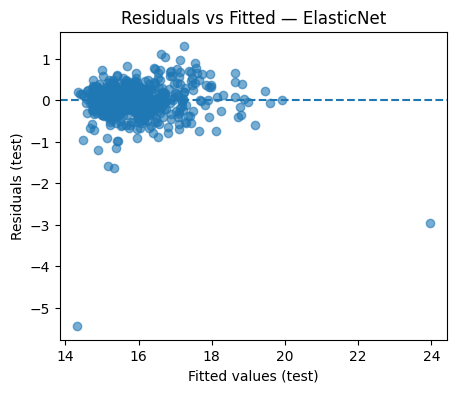

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,4))

best_model_name = summary.index[0]
pipe = best_pipes[best_model_name]
y_hat = pipe.predict(X_test)
resid = y_test - y_hat

plt.scatter(y_hat, resid, alpha=0.6)
plt.axhline(0, ls="--")
plt.xlabel("Fitted values (test)")
plt.ylabel("Residuals (test)")
plt.title(f"Residuals vs Fitted — {best_model_name}")
plt.show()

# Этап 6: Эксперименты

In [58]:
from sklearn.decomposition import PCA

# PCA только на числовые признаки, категориальные — OHE
numeric_pca = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=0.95))  # сохраняем ~95% дисперсии
])

try:
    categorical_ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
except TypeError:
    categorical_ohe = OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

preproc_pca = ColumnTransformer([
    ("num", numeric_pca, num_cols),
    ("cat", categorical_ohe, cat_cols),
])

model_pca_en = GridSearchCV(
    Pipeline([("prep", preproc_pca), ("model", ElasticNet(max_iter=50_000))]),
    param_grid={"model__alpha": np.logspace(-4,1,15), "model__l1_ratio": np.linspace(0.1,0.9,9)},
    cv=cv, scoring=scoring, n_jobs=-1
)
model_pca_en.fit(X_train, y_train)
pred = model_pca_en.predict(X_test)
print("PCA+EN:", regression_report(y_test, pred), "Best:", model_pca_en.best_params_)

PCA+EN: {'RMSE': 0.4172304920682161, 'MAE': 0.2608945525942712, 'MedAE': 0.19524251313944418, 'R2': 0.8265677886462229, 'EVS': 0.8270018890161054} Best: {'model__alpha': np.float64(0.00022758459260747887), 'model__l1_ratio': np.float64(0.9)}


In [59]:
# === FWL (Frisch–Waugh–Lovell) с совместимостью OneHotEncoder ===
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# 1) Выбери главный признак, чью β хочешь оценить "чисто" от контролей Z
X_star_name = "ceiling_height_m"  # <-- замените на нужное имя колонки
assert X_star_name in X.columns, f"{X_star_name} не найден в X.columns"

# 2) Совместимый OHE (новые и старые версии sklearn)
def make_ohe():
    try:
        return OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False)
    except TypeError:
        return OneHotEncoder(drop="first", handle_unknown="ignore", sparse=False)

# 3) Разделим X на Z (контроли) и X* (главный признак)
Z = X.drop(columns=[X_star_name])
X_star = X[[X_star_name]]

# Выделим типы для Z
num_Z = Z.select_dtypes(include=[np.number]).columns.tolist()
cat_Z = Z.select_dtypes(exclude=[np.number]).columns.tolist()

# Препроцессинг для Z (тот же на train/test)
prep_Z = ColumnTransformer(
    [("num", StandardScaler(), num_Z),
     ("cat", Pipeline([("ohe", make_ohe())]), cat_Z)],
    remainder="drop"
)

# 4) Согласуем разбиение с train/test
Z_tr, Z_te = Z.loc[X_train.index], Z.loc[X_test.index]
Xs_tr, Xs_te = X_star.loc[X_train.index], X_star.loc[X_test.index]
y_tr,  y_te  = y.loc[X_train.index],  y.loc[X_test.index]

# 5) Первая стадия: получаем остатки
# ry = y - E[y|Z]
ry_model = Pipeline([("prep", prep_Z), ("lr", LinearRegression())]).fit(Z_tr, y_tr)
ry_tr = y_tr - ry_model.predict(Z_tr)
ry_te = y_te - ry_model.predict(Z_te)

# rx = X* - E[X*|Z]  (только если X* числовой!)
if not np.issubdtype(Xs_tr[X_star_name].dtype, np.number):
    raise TypeError(f"Признак {X_star_name} не числовой. Закодируйте его в число/индикатор перед FWL.")

rx_model = Pipeline([("prep", prep_Z), ("lr", LinearRegression())]).fit(Z_tr, Xs_tr.values.ravel())
rx_tr = Xs_tr.values.ravel() - rx_model.predict(Z_tr)
rx_te = Xs_te.values.ravel() - rx_model.predict(Z_te)

# 6) Вторая стадия: регрессия ry ~ rx (+ константа)
beta_model = sm.OLS(ry_tr, sm.add_constant(rx_tr)).fit()
print(beta_model.summary())


                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.937
Date:                Mon, 27 Oct 2025   Prob (F-statistic):             0.0866
Time:                        12:17:10   Log-Likelihood:                -2672.5
No. Observations:                6398   AIC:                             5349.
Df Residuals:                    6396   BIC:                             5363.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.116e-15      0.005  -2.43e-13      1.0

In [60]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV

kf = KFold(n_splits=2, shuffle=True, random_state=SEED)
res_X, res_y = [], []

for train_idx, hold_idx in kf.split(X):
    X_tr, X_hold = X.iloc[train_idx], X.iloc[hold_idx]
    y_tr, y_hold = y.iloc[train_idx], y.iloc[hold_idx]

    # Первая стадия: ML-оценки m(Z)=E[y|Z], g(Z)=E[X*|Z]
    Z_tr = X_tr.drop(columns=[X_star_name])
    Z_hold = X_hold.drop(columns=[X_star_name])
    Xs_tr = X_tr[[X_star_name]]
    Xs_hold = X_hold[[X_star_name]]

    # одинаковый препроцессинг
    prep = ColumnTransformer([
        ("num", StandardScaler(), Z_tr.select_dtypes(include=[np.number]).columns.tolist()),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore", sparse_output=False),
         Z_tr.select_dtypes(exclude=[np.number]).columns.tolist()),
    ])

    m = Pipeline([("prep", prep), ("model", LassoCV(cv=3, random_state=SEED, max_iter=50_000))]).fit(Z_tr, y_tr)
    g = Pipeline([("prep", prep), ("model", LassoCV(cv=3, random_state=SEED, max_iter=50_000))]).fit(Z_tr, Xs_tr.values.ravel())

    ry = y_hold - m.predict(Z_hold)
    rx = Xs_hold.values.ravel() - g.predict(Z_hold)

    res_y.append(ry)
    res_X.append(rx)

# Склеиваем out-of-fold остатки и оцениваем β
res_y = np.concatenate(res_y)
res_X = np.concatenate(res_X)
ddml_beta = sm.OLS(res_y, sm.add_constant(res_X)).fit()
print(ddml_beta.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.3111
Date:                Mon, 27 Oct 2025   Prob (F-statistic):              0.577
Time:                        12:17:12   Log-Likelihood:                -4141.9
No. Observations:                7109   AIC:                             8288.
Df Residuals:                    7107   BIC:                             8302.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.005     -0.397      0.6

In [61]:
def bootstrap_rmse(y_true, y_pred, B=1000, seed=SEED):
    rng = np.random.RandomState(seed)
    n = len(y_true)
    vals = []
    for _ in range(B):
        idx = rng.randint(0, n, n)
        vals.append(float(np.sqrt(mean_squared_error(y_true.iloc[idx], y_pred[idx]))))
    lo, hi = np.percentile(vals, [2.5, 97.5])
    return np.mean(vals), (lo, hi)

# Пример для лучшей модели из summary
best_name = summary.index[0]
best_pipe = best_pipes[best_name]
pred_test = best_pipe.predict(X_test)
rmse_mean, (rmse_lo, rmse_hi) = bootstrap_rmse(y_test, pred_test, B=1000)
print(f"Bootstrap RMSE ~ {rmse_mean:.4f} (95% CI: {rmse_lo:.4f} – {rmse_hi:.4f})")


Bootstrap RMSE ~ 0.3897 (95% CI: 0.3097 – 0.5088)


In [62]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Для корректных SE используем матрицу признаков после препроцессинга
X_design = best_pipe.named_steps["prep"].transform(X_train)
X_design = sm.add_constant(X_design)
ols_sm = sm.OLS(y_train.values, X_design).fit(cov_type="HC3")
print(ols_sm.summary())

# Тест Breusch–Pagan на train
bp_stat, bp_p, _, _ = het_breuschpagan(ols_sm.resid, X_design)
print(f"Breusch–Pagan: stat={bp_stat:.2f}, p-value={bp_p:.4f}")


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                 4.609e+05
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        12:17:13   Log-Likelihood:                -2672.5
No. Observations:                6398   AIC:                             5427.
Df Residuals:                    6357   BIC:                             5704.
Df Model:                          40                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9420      0.016    866.128      0.0

In [63]:
# пример: квартиль цены (по y, в лог-шкале), можно заменить на районы/города и т.п.
q = pd.qcut(y_test, q=4, labels=["Q1","Q2","Q3","Q4"])
seg = pd.DataFrame({"y": y_test, "yhat": pred_test, "seg": q})
seg["abs_err"] = (seg["y"] - seg["yhat"]).abs()
print(seg.groupby("seg")["abs_err"].agg(["mean","median","count"]))


         mean    median  count
seg                           
Q1   0.269891  0.163130    183
Q2   0.207188  0.159417    174
Q3   0.188518  0.158595    178
Q4   0.321904  0.247879    176


In [64]:
from sklearn.linear_model import RANSACRegressor

ransac = Pipeline([
    ("prep", preprocessor),
    ("model", RANSACRegressor(random_state=SEED))
])

ransac.fit(X_train, y_train)
pred_ransac = ransac.predict(X_test)
report_ransac = regression_report(y_test, pred_ransac)
report_ransac


{'RMSE': 2.088961311244561,
 'MAE': 0.4107080663148091,
 'MedAE': 0.15589649607669287,
 'R2': -3.34748883012002,
 'EVS': -3.2856704008927835}